In [1]:
# pip install jax
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/chaotic\ cortex

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/chaotic cortex


In [2]:
from pathlib import Path
import time
import jax.numpy as jnp
import matplotlib.pyplot as plt

exec(open("functions.py").read())

In [3]:
# set basic parameters and subdirectory
part_n = 300
e_part_r = 0.8
e_mean = 4
ei_std_s = [3, 6.63]
short_interval_len = 300
subdirectory = ("{:n}_".format(part_n)
                + "{:n}_".format(e_part_r)
                + "{:n}_".format(e_mean)
                + "{0:n}-{1:n}_".format(ei_std_s[0],
                                        ei_std_s[1])
                + "{:n}/".format(short_interval_len))
#Path(subdirectory).mkdir()
print(ei_spectral_radius_fct(e_part_r, ei_std_s))

seed = 1692953915#round(time.time())
subdirectory = subdirectory + "{:n}".format(seed) + "/"
#Path(subdirectory).mkdir()
print(subdirectory)

3.9989223
300_0.8_4_3-6.63_300/1692953915/


In [4]:
# generate and save parameters for simulation
key = jax.random.PRNGKey(seed)

sub_part_r_s = jnp.asarray([e_part_r, 1 - e_part_r])
sub_part_n_s = sub_part_n_s_fct(part_n, sub_part_r_s)
unscaled_mean = ei_mean_balancer(sub_part_n_s, e_mean)
unscaled_std = jnp.tile(jnp.asarray([ei_std_s]), (2, 1))
connectivity_n = 5
in_r = 1.
rewiring_prob = 1.
[connectivity_s, key] = row_sum_removing_sparsifier(connectivity_s_generator(sub_part_n_s,
                                                                             unscaled_mean, unscaled_std,
                                                                             connectivity_n,
                                                                             key),
                                                    sub_part_n_s, in_r, rewiring_prob)
jnp.savez(subdirectory + "parameter_s_1.npz",
          sub_part_r_s, sub_part_n_s, unscaled_mean, unscaled_std,
          connectivity_n,
          in_r, rewiring_prob,
          connectivity_s)

sub_part_n_s_ext_gen = jnp.asarray([part_n])
ext_part_n = round(part_n / 100)
unscaled_ext_mean = jnp.asarray([[0.]])
unscaled_ext_std = jnp.asarray([[1.]])
ext_sub_part_r_s = jnp.asarray([1.])
ext_sub_part_n_s = sub_part_n_s_fct(ext_part_n, ext_sub_part_r_s)
ext_connectivity_n = 3
[ext_connectivity_s, key] = ext_connectivity_s_generator(sub_part_n_s_ext_gen, ext_sub_part_n_s,
                                                         unscaled_ext_mean, unscaled_ext_std,
                                                         ext_connectivity_n,
                                                         key)
jnp.savez(subdirectory + "parameter_s_2.npz",
          sub_part_n_s_ext_gen, ext_part_n, unscaled_ext_mean, unscaled_ext_std, ext_sub_part_r_s,
          ext_sub_part_n_s,
          ext_connectivity_n,
          ext_connectivity_s)

phase_n = 3
[phase_s, key] = phase_s_generator(ext_part_n, phase_n, key)
jnp.savez(subdirectory + "parameter_s_3.npz",
          phase_n,
          phase_s)

amp_s = jnp.expand_dims(jnp.asarray([0.2, 0.4, 0.8]), 1) # or (wave_n, ext_part_n) arrays so different ext parts have different amps
freq_s = jnp.full(amp_s.shape, 0.)
wave_s = jnp.concatenate([amp_s, freq_s], axis = 1)
wave_n = wave_s.shape[0]
jnp.savez(subdirectory + "parameter_s_4.npz",
          amp_s, freq_s,
          wave_s,
          wave_n)

initial_condition_mean = jnp.full((part_n, ), 0)
initial_condition_cov = jnp.identity(part_n)
initial_condition_n = 5
ext_condition_n = ext_connectivity_n * phase_n
initial_condition_n_free = initial_condition_n * ext_condition_n
[initial_condition_s, key] = initial_condition_s_generator(part_n, initial_condition_mean, initial_condition_cov, initial_condition_n_free, key)
jnp.savez(subdirectory + "parameter_s_5.npz",
          initial_condition_mean, initial_condition_cov,
          initial_condition_n,
          ext_condition_n, initial_condition_n_free,
          initial_condition_s)

condition_s = jnp.asarray([1, 1])
short_interval_n_in_long_s = jnp.asarray([1, 2])
short_interval_n = jnp.sum(short_interval_n_in_long_s)
tot_interval = jnp.asarray([0, short_interval_n * short_interval_len])
time_interval_info = [tot_interval, condition_s, short_interval_n_in_long_s]
condition_s_free = jnp.asarray([0, 0])
time_interval_info_free = [tot_interval, condition_s_free, short_interval_n_in_long_s]
jnp.savez(subdirectory + "parameter_s_6.npz",
          condition_s, short_interval_n_in_long_s,
          short_interval_n, tot_interval, time_interval_info,
          condition_s_free, time_interval_info_free)

resolution = 24
jnp.savez(subdirectory + "parameter_s_7.npz",
          resolution)

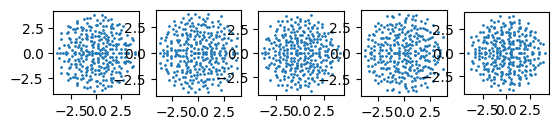

In [5]:
# plot spectra
[fig, subfig_s] = plt.subplots(1, int(connectivity_n))
for connectivity_idx in range(connectivity_n):
  temp_spectrum = jnp.linalg.eig(connectivity_s[connectivity_idx])[0]
  subfig_s[connectivity_idx].plot(jnp.real(temp_spectrum), jnp.imag(temp_spectrum),
                                  linestyle="", marker=".", markersize = 2)
  subfig_s[connectivity_idx].set_aspect('equal')

In [6]:
# run and save stats
stat_s_free = network_stat_s_fct(connectivity_s, wave_s[:1], ext_connectivity_s[:1], phase_s[:1], initial_condition_s,
                                 time_interval_info_free, resolution)
np.savez_compressed(subdirectory + "stats_free.npz", *stat_s_free) # jax has not implemented savez_compressed as of 23/08/23

stat_s = network_stat_s_fct(connectivity_s, wave_s, ext_connectivity_s, phase_s, initial_condition_s[::ext_condition_n],
                            time_interval_info, resolution)
np.savez_compressed(subdirectory + "stats.npz", *stat_s)

[5, 'connectivity_n']
[1, 'wave_n']
[1, 'ext_connectivity_n']
[1, 'phase_n']
[45, 'initial_condition_n']
[3, 'short_interval_n']
['mean_s', 'cov_s', 'short_pr_pca_s', 'long_pr_pca_s', 'mean_traj_s']
1693288480
1693288754,0
1693289028,1
1693289302,2
1693289576,3
1693289853,4
[5, 'connectivity_n']
[3, 'wave_n']
[3, 'ext_connectivity_n']
[3, 'phase_n']
[5, 'initial_condition_n']
[3, 'short_interval_n']
['mean_s', 'cov_s', 'short_pr_pca_s', 'long_pr_pca_s', 'mean_traj_s']
1693289872
1693290706,0
1693291532,1
1693292354,2
1693293184,3
1693294017,4


In [ ]:
# load parameters
[sub_part_r_s, sub_part_n_s, unscaled_mean, unscaled_std,
 connectivity_n,
 in_r, rewiring_prob,
 connectivity_s] = load_as_list(subdirectory + "parameter_s_1.npz")

[sub_part_n_s_ext_gen, ext_part_n, unscaled_ext_mean, unscaled_ext_std, ext_sub_part_r_s,
 ext_sub_part_n_s,
 ext_connectivity_n,
 ext_connectivity_s] = load_as_list(subdirectory + "parameter_s_2.npz")

[phase_n,
 phase_s] = load_as_list(subdirectory + "parameter_s_3.npz")

[amp_s, freq_s,
 wave_s,
 wave_n] = load_as_list(subdirectory + "parameter_s_4.npz")

[initial_condition_mean, initial_condition_cov,
 initial_condition_n,
 ext_condition_n, initial_condition_n_free,
 initial_condition_s] = load_as_list(subdirectory + "parameter_s_5.npz")

[condition_s, short_interval_n_in_long_s,
 short_interval_n, tot_interval, time_interval_info,
 condition_s_free, time_interval_info_free] = load_as_list(subdirectory + "parameter_s_6.npz")

[resolution] = load_as_list(subdirectory + "parameter_s_7.npz")

In [ ]:
# load stats
stat_s_free = load_as_list(subdirectory + "stats_free.npz")
stat_s = load_as_list(subdirectory + "stats.npz")

preliminary plotting

In [7]:
# for later plotting
import matplotlib.patches as mpatches
color_s = plt.rcParams['axes.prop_cycle'].by_key()['color']

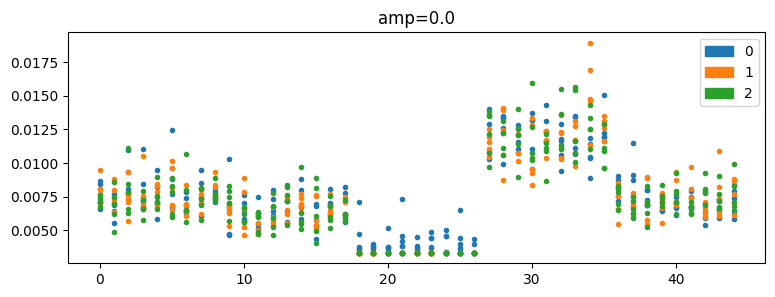

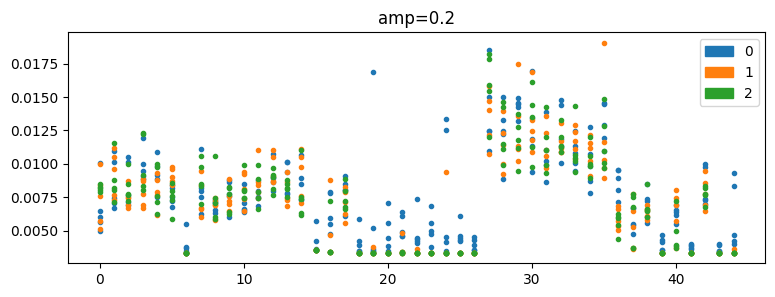

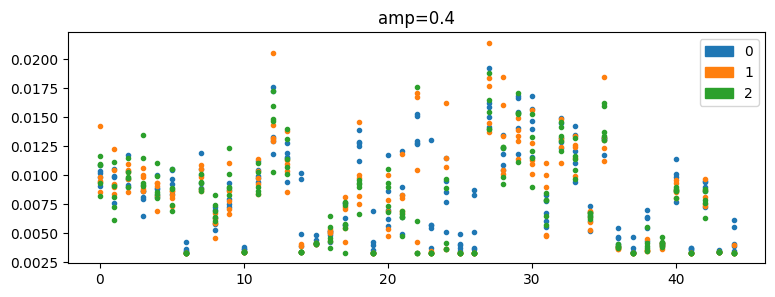

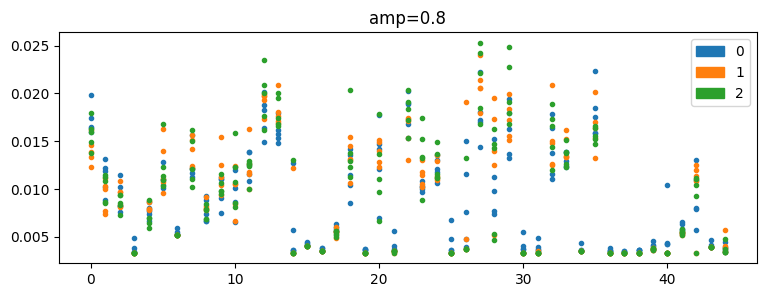

In [8]:
handle_s = [mpatches.Patch(color=color_s[short_interval_idx], label=short_interval_idx)
for short_interval_idx in range(short_interval_n)]

cov_s_free_reshaped = stat_s_free[2].reshape((connectivity_n, 1,
                                              ext_connectivity_n, phase_n, initial_condition_n,
                                              short_interval_n))
plt.figure()
plt.title("amp={}".format(0.0))
for short_interval_idx in range(short_interval_n):
  for initial_condition_idx in range(initial_condition_n):
    plt.plot(cov_s_free_reshaped[:, :, :, :, initial_condition_idx, short_interval_idx].flatten(),
              label = short_interval_idx,
              marker='.', linestyle='', color = color_s[short_interval_idx])
plt.legend(handles=handle_s, loc="upper right")
fig = plt.gcf()
fig.set_size_inches(9, 3)

for wave_idx in range(wave_s.shape[0]):
  plt.figure()
  plt.title("amp={:n}".format(wave_s[wave_idx, 0]))
  for short_interval_idx in range(jnp.sum(short_interval_n_in_long_s)):
    for initial_condition_idx in range(initial_condition_n):
      plt.plot(stat_s[2][:, wave_idx, :, :, initial_condition_idx, short_interval_idx].flatten(),
             label = short_interval_idx,
             marker='.', linestyle='', color = color_s[short_interval_idx])
  plt.legend(handles=handle_s, loc="upper right")
  fig = plt.gcf()
  fig.set_size_inches(9, 3)

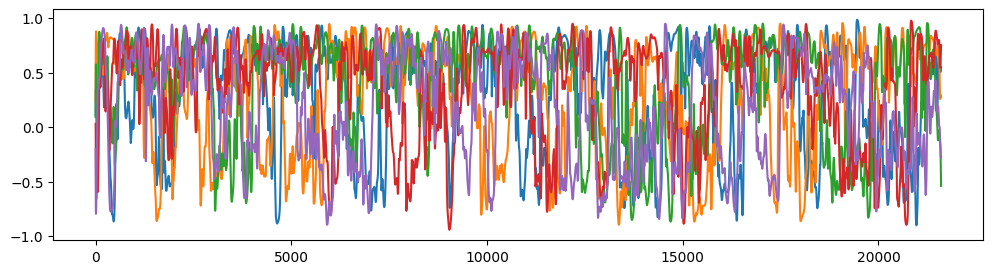

In [22]:
idx = [2,2,0,0]
samp_tr = jnp.concatenate(jnp.transpose(stat_s[4],(5,0,1,2,3,4,6)),axis = -1)
for idx2 in range(initial_condition_n):
  plt.plot(samp_tr[idx[0],idx[1],idx[2],idx[3],idx2])
fig = plt.gcf()
fig.set_size_inches(12, 3)

pr plots

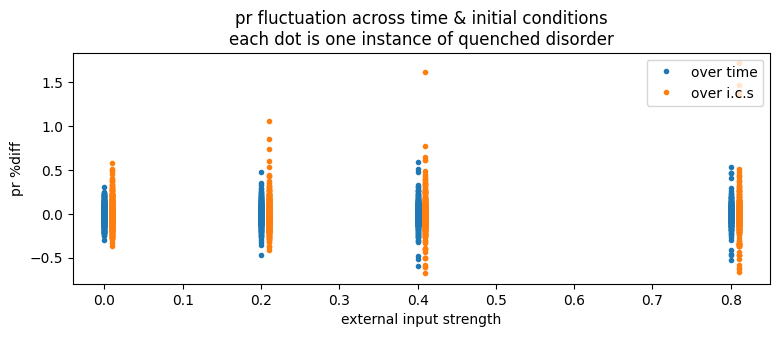

In [10]:
# pr fluctuation over time intervals and initial conditions
pr_t_mean_free = jnp.mean(stat_s_free[2][:,:,:,:,:,1:], axis = 5, keepdims = True)
pr_t_error_r_free = (stat_s_free[2][:,:,:,:,:,1:] - pr_t_mean_free) / pr_t_mean_free
pr_ic_mean_free = jnp.mean(stat_s_free[2][:,:,:,:,:,1:], axis = 4, keepdims = True)
pr_ic_error_r_free = (stat_s_free[2][:,:,:,:,:,1:] - pr_ic_mean_free) / pr_ic_mean_free

pr_t_mean = jnp.mean(stat_s[2][:,:,:,:,:,1:], axis = 5, keepdims = True)
pr_t_error_r = (stat_s[2][:,:,:,:,:,1:] - pr_t_mean) / pr_t_mean
pr_ic_mean = jnp.mean(stat_s[2][:,:,:,:,:,1:], axis = 4, keepdims = True)
pr_ic_error_r = (stat_s[2][:,:,:,:,:,1:] - pr_ic_mean) / pr_ic_mean

amp_s_all = jnp.concatenate([jnp.asarray([0.0]), jnp.ravel(amp_s)])
amp_s_all_t_plt = jnp.concatenate([jnp.full((pr_t_error_r_free.size, ), 0.0), jnp.concatenate([jnp.full((pr_t_error_r[:,wave_idx].size, ), amp_s[wave_idx]) for wave_idx in range(wave_s.shape[0])])])
amp_s_all_ic_plt = jnp.concatenate([jnp.full((pr_ic_error_r_free.size, ), 0.0), jnp.concatenate([jnp.full((pr_ic_error_r[:,wave_idx].size, ), amp_s[wave_idx]) for wave_idx in range(wave_s.shape[0])])])
pr_t_error_r_plt = jnp.concatenate([pr_t_error_r_free.flatten(), jnp.concatenate([pr_t_error_r[:,wave_idx].flatten() for wave_idx in range(wave_s.shape[0])])])
pr_ic_error_r_plt = jnp.concatenate([pr_ic_error_r_free.flatten(), jnp.concatenate([pr_ic_error_r[:,wave_idx].flatten() for wave_idx in range(wave_s.shape[0])])])

plt.figure()
plt.title("pr fluctuation across time & initial conditions"+"\neach dot is one instance of quenched disorder")
plt.plot(amp_s_all_t_plt, pr_t_error_r_plt, label = "over time",
              marker='.', linestyle='', color = color_s[0])
plt.plot(amp_s_all_ic_plt+0.01, pr_ic_error_r_plt, label = "over i.c.s",
              marker='.', linestyle='', color = color_s[1])
plt.legend(loc="upper right")
plt.xlabel("external input strength")
plt.ylabel("pr %diff")
fig = plt.gcf()
fig.set_size_inches(9, 3)

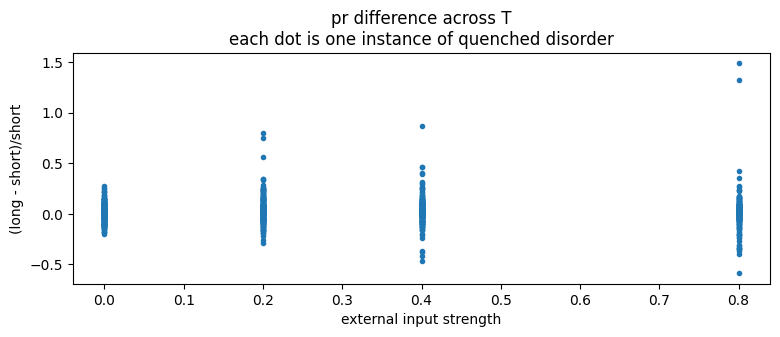

In [11]:
short_pr_mean_s_free = jnp.mean(stat_s_free[2][:,:,:,:,:,1:], axis = (4,5), keepdims = True)
pr_ls_error_r_s_free = (stat_s_free[3][:,:,:,:,:,1:] - short_pr_mean_s_free) / short_pr_mean_s_free
short_pr_mean_s = jnp.mean(stat_s[2][:,:,:,:,:,1:], axis = (4,5), keepdims = True)
pr_ls_error_r_s = (stat_s[3][:,:,:,:,:,1:] - short_pr_mean_s) / short_pr_mean_s

amp_s_all = jnp.concatenate([jnp.asarray([0.0]), jnp.ravel(amp_s)])
amp_s_all_ls_plt = jnp.concatenate([jnp.full((pr_ls_error_r_s_free.size, ), 0.0), jnp.concatenate([jnp.full((pr_ls_error_r_s[:,wave_idx].size, ), amp_s[wave_idx]) for wave_idx in range(wave_s.shape[0])])])
pr_ls_error_r_plt = jnp.concatenate([pr_ls_error_r_s_free.flatten(), jnp.concatenate([pr_ls_error_r_s[:,wave_idx].flatten() for wave_idx in range(wave_s.shape[0])])])

plt.figure()
plt.title("pr difference across T"+"\neach dot is one instance of quenched disorder")
plt.plot(amp_s_all_ls_plt, pr_ls_error_r_plt,
              marker='.', linestyle='', color = color_s[0])
#plt.legend(loc="upper right")
plt.xlabel("external input strength")
plt.ylabel("(long - short)/short")
fig = plt.gcf()
fig.set_size_inches(9, 3)

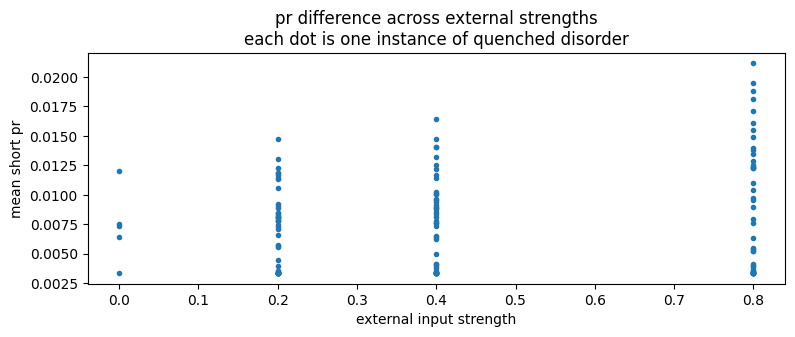

In [12]:
pr_amp_mean_s_free = jnp.mean(stat_s_free[2][:,:,:,:,:,1:], axis = (4,5), keepdims = True)
pr_amp_mean_s = jnp.mean(stat_s[2][:,:,:,:,:,1:], axis = (4,5), keepdims = True)

amp_s_all = jnp.concatenate([jnp.asarray([0.0]), jnp.ravel(amp_s)])
amp_s_all_ls_plt = jnp.concatenate([jnp.full((pr_amp_mean_s_free.size, ), 0.0), jnp.concatenate([jnp.full((pr_amp_mean_s[:,wave_idx].size, ), amp_s[wave_idx]) for wave_idx in range(wave_s.shape[0])])])
pr_amp_mean_s_plt = jnp.concatenate([pr_amp_mean_s_free.flatten(), jnp.concatenate([pr_amp_mean_s[:,wave_idx].flatten() for wave_idx in range(wave_s.shape[0])])])

plt.figure()
plt.title("pr difference across external strengths"+"\neach dot is one instance of quenched disorder")
plt.plot(amp_s_all_ls_plt, pr_amp_mean_s_plt,
              marker='.', linestyle='', color = color_s[0])
#plt.legend(loc="upper right")
plt.xlabel("external input strength")
plt.ylabel("mean short pr")
fig = plt.gcf()
fig.set_size_inches(9, 3)

tr plots

In [13]:
tr_s_free = jnp.trace(stat_s_free[1][:,:,:,:,:,1:], axis1=-1, axis2=-2)
tr_s = jnp.trace(stat_s[1][:,:,:,:,:,1:], axis1=-1, axis2=-2)
long_tr_s_free = jnp.trace(jnp.mean(stat_s_free[1][:,:,:,:,:,1:], axis = 5, keepdims = True), axis1=-1, axis2=-2)
long_tr_s = jnp.trace(jnp.mean(stat_s[1][:,:,:,:,:,1:], axis = 5, keepdims = True), axis1=-1, axis2=-2)

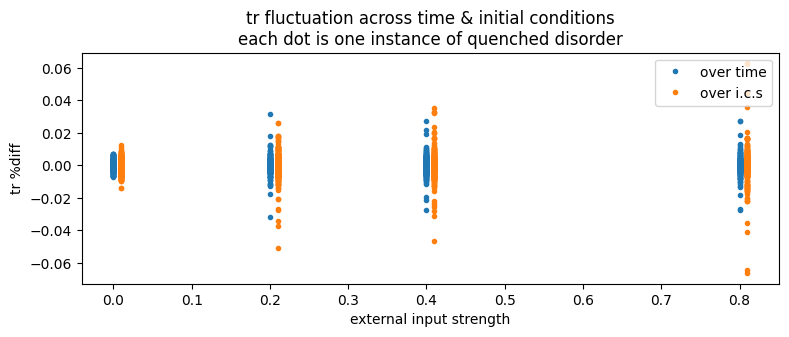

In [14]:
# det fluctuation over time intervals and initial conditions
tr_t_mean_free = jnp.mean(tr_s_free, axis = 5, keepdims = True)
tr_t_error_r_free = (tr_s_free - tr_t_mean_free) / tr_t_mean_free
tr_ic_mean_free = jnp.mean(tr_s_free, axis = 4, keepdims = True)
tr_ic_error_r_free = (tr_s_free - tr_ic_mean_free) / tr_ic_mean_free

tr_t_mean = jnp.mean(tr_s, axis = 5, keepdims = True)
tr_t_error_r = (tr_s - tr_t_mean) / tr_t_mean
tr_ic_mean = jnp.mean(tr_s, axis = 4, keepdims = True)
tr_ic_error_r = (tr_s - tr_ic_mean) / tr_ic_mean

amp_s_all = jnp.concatenate([jnp.asarray([0.0]), jnp.ravel(amp_s)])
amp_s_all_t_plt = jnp.concatenate([jnp.full((tr_t_error_r_free.size, ), 0.0), jnp.concatenate([jnp.full((tr_t_error_r[:,wave_idx].size, ), amp_s[wave_idx]) for wave_idx in range(wave_s.shape[0])])])
amp_s_all_ic_plt = jnp.concatenate([jnp.full((tr_ic_error_r_free.size, ), 0.0), jnp.concatenate([jnp.full((tr_ic_error_r[:,wave_idx].size, ), amp_s[wave_idx]) for wave_idx in range(wave_s.shape[0])])])
tr_t_error_r_plt = jnp.concatenate([tr_t_error_r_free.flatten(), jnp.concatenate([tr_t_error_r[:,wave_idx].flatten() for wave_idx in range(wave_s.shape[0])])])
tr_ic_error_r_plt = jnp.concatenate([tr_ic_error_r_free.flatten(), jnp.concatenate([tr_ic_error_r[:,wave_idx].flatten() for wave_idx in range(wave_s.shape[0])])])

plt.figure()
plt.title("tr fluctuation across time & initial conditions"+"\neach dot is one instance of quenched disorder")
plt.plot(amp_s_all_t_plt, tr_t_error_r_plt, label = "over time",
              marker='.', linestyle='', color = color_s[0])
plt.plot(amp_s_all_ic_plt+0.01, tr_ic_error_r_plt, label = "over i.c.s",
              marker='.', linestyle='', color = color_s[1])
plt.legend(loc="upper right")
plt.xlabel("external input strength")
plt.ylabel("tr %diff")
fig = plt.gcf()
fig.set_size_inches(9, 3)

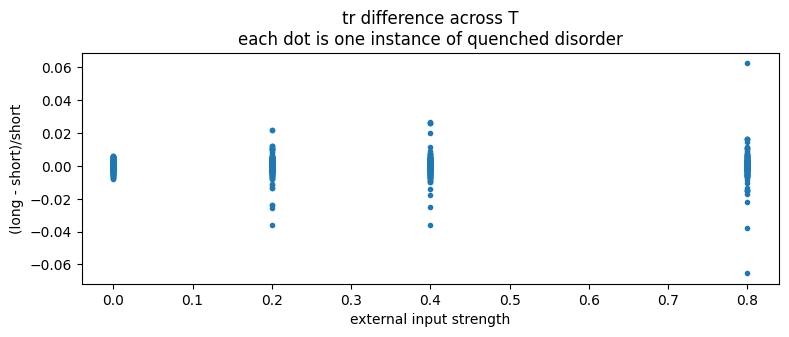

In [15]:
short_tr_mean_s_free = jnp.mean(tr_s_free, axis = (4,5), keepdims = True)
tr_ls_error_r_s_free = (long_tr_s_free - short_tr_mean_s_free) / short_tr_mean_s_free
short_tr_mean_s = jnp.mean(tr_s, axis = (4,5), keepdims = True)
tr_ls_error_r_s = (long_tr_s - short_tr_mean_s) / short_tr_mean_s

amp_s_all = jnp.concatenate([jnp.asarray([0.0]), jnp.ravel(amp_s)])
amp_s_all_ls_plt = jnp.concatenate([jnp.full((tr_ls_error_r_s_free.size, ), 0.0), jnp.concatenate([jnp.full((tr_ls_error_r_s[:,wave_idx].size, ), amp_s[wave_idx]) for wave_idx in range(wave_s.shape[0])])])
tr_ls_error_r_plt = jnp.concatenate([tr_ls_error_r_s_free.flatten(), jnp.concatenate([tr_ls_error_r_s[:,wave_idx].flatten() for wave_idx in range(wave_s.shape[0])])])

plt.figure()
plt.title("tr difference across T"+"\neach dot is one instance of quenched disorder")
plt.plot(amp_s_all_ls_plt, tr_ls_error_r_plt,
              marker='.', linestyle='', color = color_s[0])
#plt.legend(loc="upper right")
plt.xlabel("external input strength")
plt.ylabel("(long - short)/short")
fig = plt.gcf()
fig.set_size_inches(9, 3)

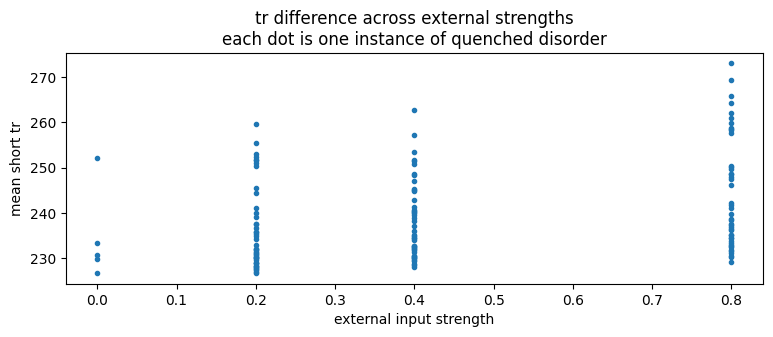

In [16]:
tr_amp_mean_s_free = jnp.mean(tr_s_free, axis = (4,5), keepdims = True)
tr_amp_mean_s = jnp.mean(tr_s, axis = (4,5), keepdims = True)

amp_s_all = jnp.concatenate([jnp.asarray([0.0]), jnp.ravel(amp_s)])
amp_s_all_ls_plt = jnp.concatenate([jnp.full((tr_amp_mean_s_free.size, ), 0.0), jnp.concatenate([jnp.full((tr_amp_mean_s[:,wave_idx].size, ), amp_s[wave_idx]) for wave_idx in range(wave_s.shape[0])])])
tr_amp_mean_s_plt = jnp.concatenate([tr_amp_mean_s_free.flatten(), jnp.concatenate([tr_amp_mean_s[:,wave_idx].flatten() for wave_idx in range(wave_s.shape[0])])])

plt.figure()
plt.title("tr difference across external strengths"+"\neach dot is one instance of quenched disorder")
plt.plot(amp_s_all_ls_plt, tr_amp_mean_s_plt,
              marker='.', linestyle='', color = color_s[0])
#plt.legend(loc="upper right")
plt.xlabel("external input strength")
plt.ylabel("mean short tr")
fig = plt.gcf()
fig.set_size_inches(9, 3)

cov plots

In [17]:
def matched_cov_similarity_s_fct(cov_1, cov_2):
  shape_1 = cov_1.shape
  shape_2 = cov_2.shape
  stack_shape = shape_1[:-2]
  stack_size = jnp.prod(jnp.asarray(stack_shape))
  cov_shape = shape_1[-2:]
  cov_1_reshaped = cov_1.reshape((stack_size, ) + cov_shape)
  cov_2_reshaped = cov_2.reshape((stack_size, ) + cov_shape)
  return(jnp.asarray([ori_similarity_fct(cov_1_reshaped[cov_idx], cov_2_reshaped[cov_idx]) for cov_idx in range(stack_size)]).reshape(stack_shape))
#matched_cov_similarity_s_fct = jax.jit(matched_cov_similarity_s_fct)

In [18]:
#free similarities
cov_t_similarity_s_free = matched_cov_similarity_s_fct(stat_s_free[1][:,:,:,:,:,(1+1):], stat_s_free[1][:,:,:,:,:,1:-1])

cov_ic_similarity_s_free = matched_cov_similarity_s_fct(stat_s_free[1][:,:,:,:,1:,1:], stat_s_free[1][:,:,:,:,:-1,1:])

long_cov_s_free = jnp.mean(stat_s_free[1][:,:,:,:,:,1:], axis = 5)
cov_ls_similarity_s_free = [matched_cov_similarity_s_fct(stat_s_free[1][:,:,:,:,:,short_interval_idx], long_cov_s_free)
for short_interval_idx in range(1, short_interval_n)]

# cov_s_ext_reshaped_free = stat_s_free[1].reshape((connectivity_n, wave_n, ext_condition_n, initial_condition_n, short_interval_n, part_n, part_n))
# cov_ext_similarity_s_free = matched_cov_similarity_s_fct(cov_s_ext_reshaped_free[:,:,1:,:,1:], cov_s_ext_reshaped_free[:,:,:-1,:,1:])

cov_sys_similarity_s_free = matched_cov_similarity_s_fct(stat_s_free[1][1:,:,:,:,:,1:], stat_s_free[1][:-1,:,:,:,:,1:])

In [19]:
#driven similarities
cov_t_similarity_s = matched_cov_similarity_s_fct(stat_s[1][:,:,:,:,:,(1+1):], stat_s[1][:,:,:,:,:,1:-1])

cov_ic_similarity_s = matched_cov_similarity_s_fct(stat_s[1][:,:,:,:,1:,1:], stat_s[1][:,:,:,:,:-1,1:])

long_cov_s = jnp.mean(stat_s[1][:,:,:,:,:,1:], axis = 5)
cov_ls_similarity_s = [matched_cov_similarity_s_fct(stat_s[1][:,:,:,:,:,short_interval_idx], long_cov_s)
for short_interval_idx in range(1, short_interval_n)]

cov_s_ext_reshaped = stat_s[1].reshape((connectivity_n, wave_n, ext_condition_n, initial_condition_n, short_interval_n, part_n, part_n))
cov_ext_similarity_s = matched_cov_similarity_s_fct(cov_s_ext_reshaped[:,:,1:,:,1:], cov_s_ext_reshaped[:,:,:-1,:,1:])

cov_sys_similarity_s = matched_cov_similarity_s_fct(stat_s[1][1:,:,:,:,:,1:], stat_s[1][:-1,:,:,:,:,1:])

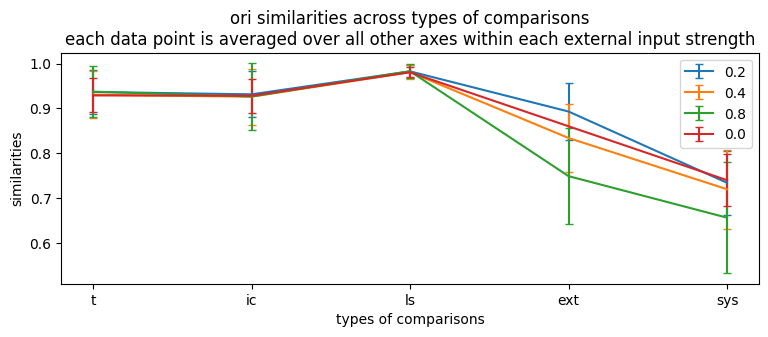

In [20]:
plt.figure()
plt.title("ori similarities across types of comparisons"+"\neach data point is averaged over all other axes within each external input strength")
for wave_idx in range(wave_n):
  plt.errorbar(["t", "ic", "ls", "ext", "sys"],
 [jnp.mean(cov_t_similarity_s[:,wave_idx]), jnp.mean(cov_ic_similarity_s[:,wave_idx]), jnp.mean(jnp.asarray(cov_ls_similarity_s)[:,:,wave_idx]), jnp.mean(cov_ext_similarity_s[:,wave_idx]), jnp.mean(cov_sys_similarity_s[:,wave_idx])],
             yerr = [jnp.std(cov_t_similarity_s[:,wave_idx]), jnp.std(cov_ic_similarity_s[:,wave_idx]), jnp.std(jnp.asarray(cov_ls_similarity_s)[:,:,wave_idx]), jnp.std(cov_ext_similarity_s[:,wave_idx]), jnp.std(cov_sys_similarity_s[:,wave_idx])],
              capsize = 3, color = color_s[wave_idx], label = wave_s[wave_idx,0])
plt.errorbar(["t", "ic", "ls", "sys"],
 [jnp.mean(cov_t_similarity_s_free), jnp.mean(cov_ic_similarity_s_free), jnp.mean(jnp.asarray(cov_ls_similarity_s_free)), jnp.mean(cov_sys_similarity_s_free)],
             yerr = [jnp.std(cov_t_similarity_s_free), jnp.std(cov_ic_similarity_s_free), jnp.std(jnp.asarray(cov_ls_similarity_s_free)), jnp.std(cov_sys_similarity_s_free)],
              capsize = 3, color = color_s[wave_n], label = 0.0)
plt.legend(loc="upper right")
plt.xlabel("types of comparisons")
plt.ylabel("similarities")
fig = plt.gcf()
fig.set_size_inches(9, 3)

det plots

In [ ]:
det_s_free = jnp.linalg.det(stat_s_free[1][:,:,:,:,:,1:])
det_s = jnp.linalg.det(stat_s[1][:,:,:,:,:,1:])
long_det_s_free = jnp.linalg.det(jnp.mean(stat_s_free[1][:,:,:,:,:,1:], axis = 5))
long_det_s = jnp.linalg.det(jnp.mean(stat_s[1][:,:,:,:,:,1:], axis = 5))

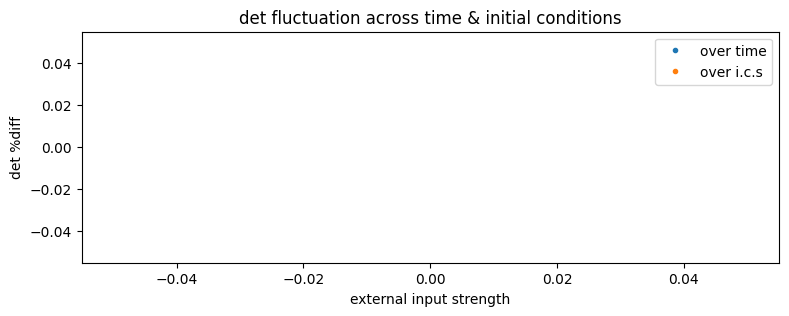

In [ ]:
# det fluctuation over time intervals and initial conditions
det_t_mean_free = jnp.mean(det_s_free, axis = 5, keepdims = True)
det_t_error_r_free = (det_s_free - det_t_mean_free) / det_t_mean_free
det_ic_mean_free = jnp.mean(det_s_free, axis = 4, keepdims = True)
det_ic_error_r_free = (det_s_free - det_ic_mean_free) / det_ic_mean_free

det_t_mean = jnp.mean(det_s, axis = 5, keepdims = True)
det_t_error_r = (det_s - det_t_mean) / det_t_mean
det_ic_mean = jnp.mean(det_s, axis = 4, keepdims = True)
det_ic_error_r = (det_s - det_ic_mean) / det_ic_mean

amp_s_all = jnp.concatenate([jnp.asarray([0.0]), jnp.ravel(amp_s)])
amp_s_all_t_plt = jnp.concatenate([jnp.full((det_t_error_r_free.size, ), 0.0), jnp.concatenate([jnp.full((det_t_error_r[:,wave_idx].size, ), amp_s[wave_idx]) for wave_idx in range(wave_s.shape[0])])])
amp_s_all_ic_plt = jnp.concatenate([jnp.full((det_ic_error_r_free.size, ), 0.0), jnp.concatenate([jnp.full((det_ic_error_r[:,wave_idx].size, ), amp_s[wave_idx]) for wave_idx in range(wave_s.shape[0])])])
det_t_error_r_plt = jnp.concatenate([det_t_error_r_free.flatten(), jnp.concatenate([det_t_error_r[:,wave_idx].flatten() for wave_idx in range(wave_s.shape[0])])])
det_ic_error_r_plt = jnp.concatenate([det_ic_error_r_free.flatten(), jnp.concatenate([det_ic_error_r[:,wave_idx].flatten() for wave_idx in range(wave_s.shape[0])])])

plt.figure()
plt.title("det fluctuation across time & initial conditions")
plt.plot(amp_s_all_t_plt, det_t_error_r_plt, label = "over time",
              marker='.', linestyle='', color = color_s[0])
plt.plot(amp_s_all_ic_plt+0.01, det_ic_error_r_plt, label = "over i.c.s",
              marker='.', linestyle='', color = color_s[1])
plt.legend(loc="upper right")
plt.xlabel("external input strength")
plt.ylabel("det %diff")
fig = plt.gcf()
fig.set_size_inches(9, 3)

In [ ]:
short_det_mean_s_free = jnp.mean(det_s_free, axis = (4,5), keepdims = True)
det_ls_error_r_s_free = (long_det_s_free - short_det_mean_s_free) / short_det_mean_s_free
short_det_mean_s = jnp.mean(det_s, axis = (4,5), keepdims = True)
det_ls_error_r_s = (long_det_s - short_det_mean_s) / short_det_mean_s

amp_s_all = jnp.concatenate([jnp.asarray([0.0]), jnp.ravel(amp_s)])
amp_s_all_ls_plt = jnp.concatenate([jnp.full((det_ls_error_r_s_free.size, ), 0.0), jnp.concatenate([jnp.full((det_ls_error_r_s[:,wave_idx].size, ), amp_s[wave_idx]) for wave_idx in range(wave_s.shape[0])])])
det_ls_error_r_plt = jnp.concatenate([det_ls_error_r_s_free.flatten(), jnp.concatenate([det_ls_error_r_s[:,wave_idx].flatten() for wave_idx in range(wave_s.shape[0])])])

plt.figure()
plt.title("det fluctuation across T")
plt.plot(amp_s_all_ls_plt, det_ls_error_r_plt,
              marker='.', linestyle='', color = color_s[0])
#plt.legend(loc="upper right")
plt.xlabel("external input strength")
plt.ylabel("(long - short)/short")
fig = plt.gcf()
fig.set_size_inches(9, 3)

In [ ]:
det_amp_mean_s_free = jnp.mean(det_s_free, axis = (4,5), keepdims = True)
det_amp_mean_s = jnp.mean(det_s, axis = (4,5), keepdims = True)

amp_s_all = jnp.concatenate([jnp.asarray([0.0]), jnp.ravel(amp_s)])
amp_s_all_ls_plt = jnp.concatenate([jnp.full((det_amp_mean_s_free.size, ), 0.0), jnp.concatenate([jnp.full((det_amp_mean_s[:,wave_idx].size, ), amp_s[wave_idx]) for wave_idx in range(wave_s.shape[0])])])
det_amp_mean_s_plt = jnp.concatenate([det_amp_mean_s_free.flatten(), jnp.concatenate([det_amp_mean_s[:,wave_idx].flatten() for wave_idx in range(wave_s.shape[0])])])

plt.figure()
plt.title("det difference across external strengths")
plt.plot(amp_s_all_ls_plt, det_amp_mean_s_plt,
              marker='.', linestyle='', color = color_s[0])
#plt.legend(loc="upper right")
plt.xlabel("external input strength")
plt.ylabel("mean short det")
fig = plt.gcf()
fig.set_size_inches(9, 3)

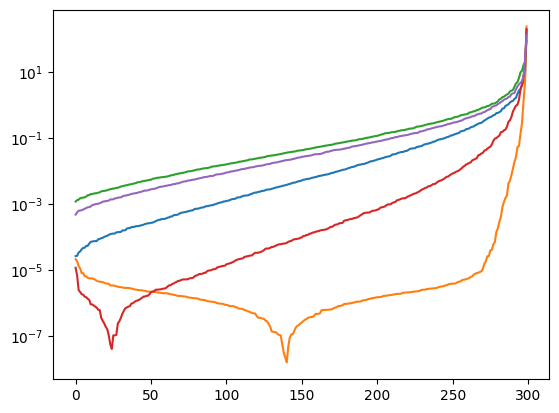

In [ ]:
for connectivity_idx in range(connectivity_n):
  plt.plot(jnp.absolute(jnp.linalg.eigh(stat_s[1][connectivity_idx,1,1,1,1,2])[0]))
plt.yscale("log")